In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using FITSIO
using LinearAlgebra
using PythonCall
using ForwardDiff
using Plots
np = pyimport("numpy")

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


Python module: <module 'numpy' from '/home/jaime/.julia/environments/v1.7/.CondaPkg/env/lib/python3.11/site-packages/numpy/__init__.py'>

# Analytic Margninalization

## T-Matrices wlwl dz

In [4]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
#fol = "DESY1"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairss = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [5]:
function model_cov(x;
               tracers_names=tracers_names,
               pairss=pairss,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_dz" => x[1],
                     "DESwl__1_e_dz" => x[2],
                     "DESwl__2_e_dz" => x[3],
                     "DESwl__3_e_dz" => x[4],
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairss,
                  idx, files; Nuisances=nuisances)
end;

In [6]:
d = 0.00005
n_cls = 240
m  = 4
T = zeros(n_cls, m)

for i in 1:m
    dz = zeros(m)
    e = zeros(m)
    e[i] = d
    T[:, i] = (model_cov(dz.+e) .- model_cov(dz.-e)) ./ (2*d)
end

In [7]:
dz_cov = [0.017^2 0 0 0; 
          0 0.017^2 0 0;
          0 0 0.013^2 0;
          0 0 0 0.015^2] 

4×4 Matrix{Float64}:
 0.000289  0.0       0.0       0.0
 0.0       0.000289  0.0       0.0
 0.0       0.0       0.000169  0.0
 0.0       0.0       0.0       0.000225

In [8]:
TPT = T * dz_cov * T'

240×240 Matrix{Float64}:
 6.55468e-20  3.40506e-20  2.14517e-20  …  0.0          0.0
 3.40506e-20  1.76888e-20  1.11439e-20     0.0          0.0
 2.14517e-20  1.11439e-20  7.02059e-21     0.0          0.0
 1.53237e-20  7.96042e-21  5.01503e-21     0.0          0.0
 1.18035e-20  6.13175e-21  3.86298e-21     0.0          0.0
 9.58113e-21  4.97726e-21  3.13565e-21  …  0.0          0.0
 8.07121e-21  4.19288e-21  2.6415e-21      0.0          0.0
 6.94511e-21  3.60788e-21  2.27295e-21     0.0          0.0
 6.01233e-21  3.12332e-21  1.96768e-21     0.0          0.0
 5.21803e-21  2.71069e-21  1.70772e-21     0.0          0.0
 4.53737e-21  2.3571e-21   1.48496e-21  …  0.0          0.0
 3.94869e-21  2.05129e-21  1.2923e-21      0.0          0.0
 3.43389e-21  1.78386e-21  1.12382e-21     0.0          0.0
 ⋮                                      ⋱               
 0.0          0.0          0.0             1.12259e-22  9.57897e-23
 0.0          0.0          0.0             9.50676e-23  8.11207e-23
 0

In [9]:
C_mod = Symmetric(cov_tot + TPT);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  1.26842e18   1.59641e17  -6.57338e15  …  -3.80427e15  -4.42146e15
  1.59641e17   2.63374e18   2.93227e17     -1.88945e15  -2.34235e15
 -6.57338e15   2.93227e17   4.01124e18     -1.50475e15  -1.95076e15
 -8.25376e15  -6.32952e15   4.35281e17     -1.2157e15   -1.66498e15
 -7.64114e15  -1.30102e16   3.22067e15     -9.42765e14  -1.39672e15
 -6.92276e15  -1.51406e16  -1.11653e16  …  -7.3416e14   -1.19537e15
 -7.0962e15   -1.6782e16   -1.77185e16     -5.8521e14   -1.0541e15
 -7.31311e15  -1.84349e16  -2.25220e16     -5.02965e14  -1.01232e15
 -8.35562e15  -2.18792e16  -2.74846e16     -4.65526e14  -1.06865e15
 -9.23584e15  -2.50829e16  -3.27665e16     -4.16613e14  -1.13205e15
 -1.04317e16  -2.87491e16  -3.78199e16  …  -3.75524e14  -1.19828e15
 -1.23194e16  -3.42842e16  -4.56467e16     -3.56869e14  -1.32153e15
 -1.41778e16  -3.9769e16   -5.32266e16     -3.44781e14  -1.45562e15
  ⋮                                     ⋱               
 -4.31429e14   

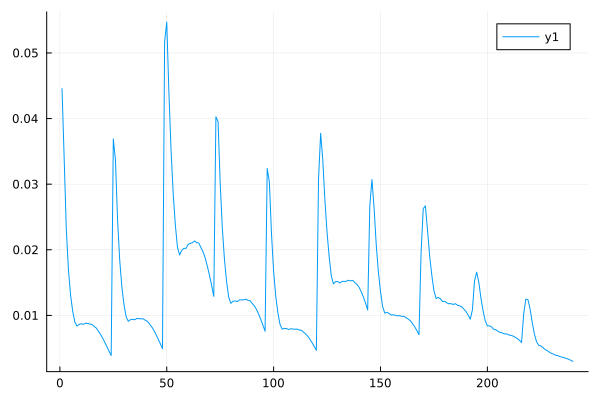

In [10]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [38]:
npzwrite("../data/DESY1/binned_40_nzs/wlwl_dz_cov_marg.npz",
        Dict("TPT" => TPT,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices wlwl

In [39]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e");

In [40]:
cov_k0 = Diagonal(cov_k0)
cov_k1 = Diagonal(cov_k1)
cov_k2 = Diagonal(cov_k2)
cov_k3 = Diagonal(cov_k3)

40×40 Diagonal{Float64, Vector{Float64}}:
 1.38363e-6   ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅          2.10309e-5   ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅          1.03732e-5      ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
 ⋮                                   ⋱                          
  ⋅      

In [41]:
println(np.average(zs_k0, weights=nz_k0))
println(np.average(zs_k1, weights=nz_k1))
println(np.average(zs_k2, weights=nz_k2))
println(np.average(zs_k3, weights=nz_k3))

0.3593318851787447
0.4909224834984977
0.7658070710228834
0.9799214358359419


In [42]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => x,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => x,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => x,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => x,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [43]:
d = 0.005
n_cls = 240
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [44]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [45]:
TT0 = T0 * (cov_k0) * T0'
TT1 = T1 * (cov_k1) * T1'
TT2 = T2 * (cov_k2) * T2'
TT3 = T3 * (cov_k3) * T3';

In [46]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  7.75147e19  -6.01798e18  -6.18812e18  …   9.05699e17   1.11376e18
 -6.01798e18   1.55467e20  -7.58813e18      5.79433e17   7.78836e17
 -6.18812e18  -7.58813e18   2.42363e20      5.20903e17   6.70152e17
 -6.17648e18  -7.59316e18  -8.02924e18      6.0196e17    7.608e17
 -6.15122e18  -7.55478e18  -8.01452e18      7.93739e17   9.86253e17
 -6.09538e18  -7.46776e18  -7.93676e18  …   1.02472e18   1.24576e18
 -6.05833e18  -7.40012e18  -7.86961e18      1.23884e18   1.48327e18
 -6.43239e18  -7.83325e18  -8.33086e18      1.52822e18   1.80853e18
 -7.40599e18  -8.99175e18  -9.56036e18      1.98852e18   2.32732e18
 -8.37185e18  -1.01355e19  -1.0771e19       2.46177e18   2.8445e18
 -9.32121e18  -1.12568e19  -1.19554e19  …   2.88707e18   3.28238e18
 -1.06309e19  -1.28126e19  -1.35998e19      3.34112e18   3.71629e18
 -1.18768e19  -1.42935e19  -1.5165e19       3.62945e18   3.9087e18
  ⋮                                     ⋱               
  7.1153e16   -1.3

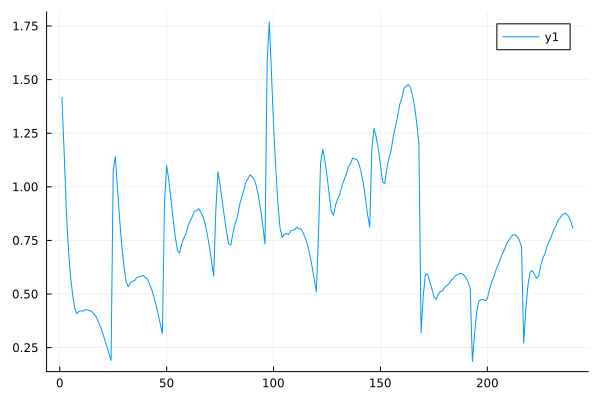

In [47]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [49]:
npzwrite("../../data/DESY1/binned_40_nzs/wlwl_cov_marg_lsst_diag.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices gcgc

In [70]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
data_set = "gcgc_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESgc__0_0")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESgc__1_0")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESgc__2_0")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESgc__3_0")
zs_k4, nz_k4, cov_k4 = get_nzs(nz_path, "DESgc__4_0")

([0.6551, 0.6651, 0.6751, 0.6851, 0.6951, 0.7051000000000001, 0.7151, 0.7251, 0.7351, 0.7451  …  0.9551000000000001, 0.9651, 0.9751, 0.9851, 0.9951, 1.0050999999999999, 1.0151000000000001, 1.0251, 1.0351000000000001, 1.0451], [7.122190259874889e-5, 0.00023693095142791895, 0.0007163549450023793, 0.0011461243782359425, 0.002060276981448135, 0.004010500779354668, 0.007813801770069977, 0.012445219895066476, 0.017980282024427585, 0.024881651026434092  …  0.0019871031262275337, 0.0012026898458187502, 0.000608660805254952, 0.0002656764127644467, 0.00019069985344643062, 9.321117148275464e-5, 0.0002329993835371008, 0.00011861962402017041, 6.716824627770055e-5, 2.174713749402883e-5], [2.7930037054506526e-7 0.0 … 0.0 0.0; 0.0 3.537541846902938e-7 … 0.0 0.0; … ; 0.0 0.0 … 2.775891502403637e-7 0.0; 0.0 0.0 … 0.0 2.5877452507588106e-7])

In [71]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => x,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__4_0_nz" => nz_k4,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64,
                     "DESgc__4_0_b" => 1.84)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => x,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__4_0_nz" => nz_k4,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64,
                     "DESgc__4_0_b" => 1.84)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => x,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__4_0_nz" => nz_k4,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64,
                     "DESgc__4_0_b" => 1.84)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => x,
                     "DESgc__4_0_nz" => nz_k4,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64,
                     "DESgc__4_0_b" => 1.84)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov4(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__4_0_nz" => x,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64,
                     "DESgc__4_0_b" => 1.84)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [76]:
d = 0.00000005
n_cls = 47
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)
T4 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
    T4[:, i] = (model_cov4(nz_k4.+e) .- model_cov4(nz_k4.-e)) ./ (2*d)
end

40


In [77]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [78]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3'
TT4 = T4 * cov_k4 * T4';

In [79]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3 + TT4);
inv_C_mod = inv(C_mod)

47×47 Symmetric{Float64, Matrix{Float64}}:
   2.98135e8     2.78496e8    -3.46214e7  …     -34.8995         -17.8957
   2.78496e8     4.21667e9     1.16788e9         85.803         -334.954
  -3.46214e7     1.16788e9     2.2323e10        169.784         -128.237
  -5.76059e7    -6.96216e8     3.33124e9       -508.439          103.682
  -1.61119e8    -1.09121e9    -2.42042e9         21.813          491.56
  -7.23369e6    -3.58621e6     3.08226e6  …    6434.75          2487.56
  -4.01414e6    -6.82503e7    -8.58551e6     -10468.6          45051.1
   1.60393e6    -1.09589e7    -2.85878e8     -18644.1          20881.8
   2.78281e6     1.71558e7    -1.55189e7      73084.8          -4114.59
   5.01137e6     2.66775e7     6.62945e7      -2235.33        -62399.8
   4.32693e6     2.09752e7     5.47698e7  …   -6913.56         21873.3
   6.24506e6     2.82026e7     7.33961e7     -10367.6         -42614.4
   6.67313e6     2.82387e7     7.53502e7     -39797.0          33724.6
   ⋮                  

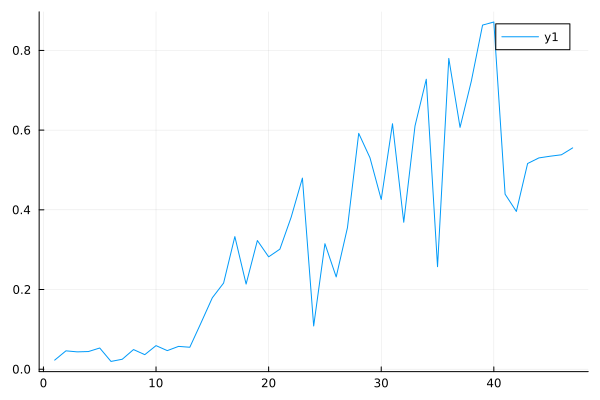

In [80]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [84]:
npzwrite("../../data/DESY1/binned_40_nzs/gcgc_cov_marg.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "TPT3" => TT4,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

# Likelihood

In [2]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "gcgc_Nzs_40_carlos"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

names = pyconvert(Vector{String}, meta["names"])
types = pyconvert(Vector{String}, meta["types"])
pairss = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [3]:
cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                 nk=300, nz=300, nz_pk=300,
                                 tk_mode="EisHu",
                                 Pk_mode="Halofit", 
                                 emul_path="../../emulator/files.npz")

fake_data = Theory(cosmology, names, types, pairss,
                   idx, files);

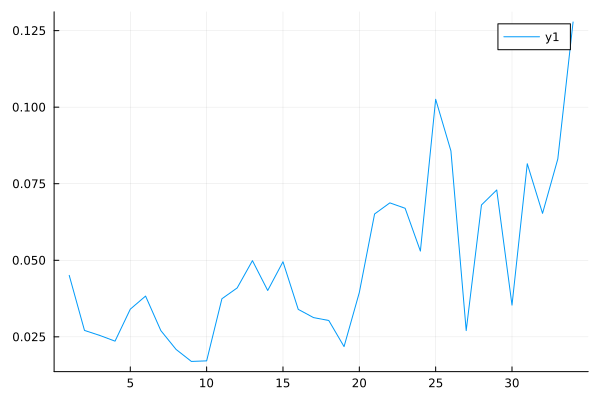

In [4]:
plot(abs.(fake_data .- data_vector) ./data_vector)

In [8]:
function get_cls(Ωm, s8;
               tracers_names=tracers_names,
               pairss=pairss,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    Ωb = 0.05
    h = 0.67
    ns = 0.96

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    DESwl__0_b = 1.21
    DESwl__1_b = 1.30
    DESwl__2_b = 1.48
    DESwl__3_b = 1.64

    nuisances = Dict("DESwl__0_b" => DESwl__0_b,
                     "DESwl__1_b" => DESwl__1_b,
                     "DESwl__2_b" => DESwl__2_b,
                     "DESwl__3_b" => DESwl__3_b,)
    
    
    return Theory(cosmology, names, types, pairss,
                  idx, files; Nuisances=nuisances)
end;


In [9]:
function get_Xi2(Ωm, s8;
                 tk_mode="EisHu",
                 data=data_vector,
                 inv_cov=inv_cov_tot)

    DESwl__0_b = 1.21
    DESwl__1_b = 1.30
    DESwl__2_b = 1.48
    DESwl__3_b = 1.64

    nuisances = Dict("DESwl__0_b" => DESwl__0_b,
                     "DESwl__1_b" => DESwl__1_b,
                     "DESwl__2_b" => DESwl__2_b,
                     "DESwl__3_b" => DESwl__3_b,)
    

    Ωb = 0.05
    h = 0.67
    ns = 0.96
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8;
                                     nk=300, nz=300, nz_pk=100,
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit", 
                                     emul_path="../../emulator/files.npz")
    
    theory = Theory(cosmology, names, types, pairss,
                    idx, files)
    
    diff = @.(theory-data)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [10]:
Ωms = LinRange(0.2, 0.6, 30)
s8s = LinRange(0.6, 0.9, 30)

30-element LinRange{Float64, Int64}:
 0.6,0.610345,0.62069,0.631034,0.641379,…,0.868966,0.87931,0.889655,0.9

In [11]:
LinRange(0, 3, 100)

100-element LinRange{Float64, Int64}:
 0.0,0.030303,0.0606061,0.0909091,…,2.87879,2.90909,2.93939,2.9697,3.0

In [12]:
get_Xi2(0.30, 0.81)

2.378526475230396e6

In [10]:
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
    end
end

LoadError: MethodError: no method matching LinRange(::Float64; stop=1.0986122886681098, length=100)
[0mClosest candidates are:
[0m  LinRange(::Any, [91m::Any[39m, [91m::Integer[39m) at /opt/julia-1.7.0/share/julia/base/range.jl:521[91m got unsupported keyword arguments "stop", "length"[39m
[0m  LinRange([91m::AbstractRange{T}[39m) where T at /opt/julia-1.7.0/share/julia/base/range.jl:1262[91m got unsupported keyword arguments "stop", "length"[39m

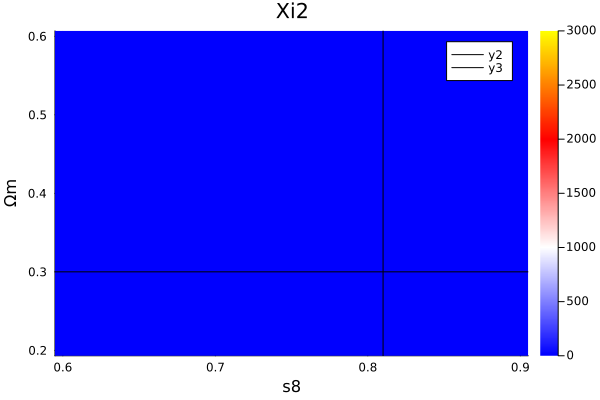

In [11]:
gr()
heatmap(s8s, Ωms, Xi2s_EisHu,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clims = (0, 3000),
    title="Xi2")
vline!([0.81], c=:black)
hline!([0.3], c=:black)